<a href="https://colab.research.google.com/github/siting1206/NLP_HW1/blob/main/NER_Model_1031.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [588]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

In [589]:
%matplotlib inline
import time
import numpy as np
import pandas as pd
import random
import collections

import matplotlib.pyplot as plt

from collections import namedtuple
from tensorflow.keras.preprocessing.sequence import pad_sequences

import regex as re
import os, string, sys

from gensim.models.word2vec import Word2Vec

In [590]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [591]:
class RegexFeatures(object):
    PATTERNS = {
        "repeatedPunctuation": re.compile(r'^[\.\,!\?"\':;_\-]{2,}$'),
        "isNumber": re.compile(r'^((\p{N}{,2}([,]?\p{N}{3})+)(\.\p{N}+)?)$'),
        "isURL": re.compile(r'^http[s]?://'),
        "isMention": re.compile(r'^(RT)?@[\p{Alnum}_]+$'),
        "isHashtag": re.compile(r'^#\p{Alnum}+$'),
        "isMoney": re.compile(r'^\$((\p{N}{,2}([,]?\p{N}{3})+)(\.\p{N}+)?)$'),
    }
    def __init__(self):
        print("Initialized RegexFeature")
    def process(word):
        features = dict()
        for k, p in RegexFeatures.PATTERNS.iteritems():
            if p.match(word):
                features[k] = True
        return features


Tag = namedtuple("Tag", ["token", "tag"])

def load_sequences(filename, sep="\t", notypes=False, test_data=False):
    sequences = []
    with open(filename) as fp:
        seq = []
        for line in fp:
            line = line.strip()
            if line:
                line = line.split(sep)
                seq.append(Tag(*line))
            else:
                sequences.append(seq)
                seq = []
        if seq:
            sequences.append(seq)
    return sequences

def load_test_sequences(filename, sep="\t"):
    sequences = []
    with open(filename) as fp:
        seq = []
        for line in fp:
          line = line.strip()
          if line:
            seq.append(line)
          else:
            sequences.append(seq)
            seq = []
        if seq:
          sequences.append(seq)
    return sequences

In [592]:
train_sequences = load_sequences("drive/MyDrive/NLP_assignment1/data/train.txt", sep="\t", notypes=True)
dev_sequences = load_sequences("drive/MyDrive/NLP_assignment1/data/dev.txt", sep="\t", notypes=False)
test_sequences = load_test_sequences("drive/MyDrive/NLP_assignment1/data/test-submit.txt", sep="\t")

In [593]:
train_sentences = [[t[0] for t in seq] for seq in (train_sequences)]
train_tags = [[t[1] for t in seq] for seq in (train_sequences)]

valid_sentences = [[t[0] for t in seq] for seq in (dev_sequences)]
valid_tags = [[t[1] for t in seq] for seq in (dev_sequences)]

# print(train_sentences)

In [594]:
other_entities = {
    "isHashtag": [],
    "isMention": [],
    "isURL": [],
    "isMoney": [],
    "isNumber": [],
    "repeatedPunctuation": []
}
for seq in train_sentences:
    for t in seq:
        for k in other_entities.keys():
            if RegexFeatures.PATTERNS[k].match(t):
                other_entities[k].append(t)
for k, v in other_entities.items():
    print(k, len(v))

isHashtag 440
isMention 1292
isURL 448
isMoney 5
isNumber 120
repeatedPunctuation 1059


In [595]:
ENTITY_MAPPINGS={k: "__%s__" % k for k in other_entities.keys()}
ENTITY_MAPPINGS

{'isHashtag': '__isHashtag__',
 'isMention': '__isMention__',
 'isURL': '__isURL__',
 'isMoney': '__isMoney__',
 'isNumber': '__isNumber__',
 'repeatedPunctuation': '__repeatedPunctuation__'}

In [596]:
def preprocess_token(x, to_lower=False):
    for k in ENTITY_MAPPINGS.keys():
        if RegexFeatures.PATTERNS[k].match(x):
            return ENTITY_MAPPINGS[k]
    if to_lower:
        x = x.lower()
    return x

In [597]:
train_pre_seq = [[preprocess_token(t[0], to_lower=False) for t in seq] for seq in train_sequences]
dev_pre_seq = [[preprocess_token(t[0], to_lower=False) for t in seq] for seq in dev_sequences]
test_pre_seq = [[preprocess_token(t, to_lower=False) for t in seq] for seq in test_sequences]

In [598]:
words = []
for seq in (train_pre_seq+dev_pre_seq):
  for word in seq:
    words.append(word)
print(len(words))

62730


In [599]:
word2vec_sentences = [preprocess_token(t[0], to_lower=False) for seq in train_sequences for t in seq]
tag2vec_sentences = [t[1] for seq in train_sequences for t in seq]
s_words=list(set(word2vec_sentences))
s_tags=list(set(tag2vec_sentences))
w_index={t:j for j,t in enumerate(s_words)}
t_index={t:j+1 for j,t in enumerate(s_tags)}
print(t_index)
n_words = len(w_index)
n_tags = len(t_index)
y_train = [[t_index[w[1]] for w in s] for s in train_sequences]
y_valid = [[t_index[w[1]] for w in s] for s in dev_sequences]

{'I-company': 1, 'B-movie': 2, 'I-musicartist': 3, 'B-product': 4, 'I-sportsteam': 5, 'I-product': 6, 'B-other': 7, 'I-geo-loc': 8, 'I-other': 9, 'B-sportsteam': 10, 'B-tvshow': 11, 'B-musicartist': 12, 'B-person': 13, 'B-geo-loc': 14, 'B-facility': 15, 'I-person': 16, 'I-facility': 17, 'I-tvshow': 18, 'I-movie': 19, 'B-company': 20, 'O': 21}


In [600]:
train_maxl = max([len(s) for s in train_pre_seq])
dev_maxl = max([len(s) for s in dev_pre_seq])
# print ('Maximum length in the list of train_sentences:', train_maxl)
# print ('Maximum length in the list of dev_sentences:', dev_maxl)
maxl = max(train_maxl, dev_maxl)

In [601]:
def build_dataset(words, vocabulary_size=10000):
    token_count = [['UNK', -1]]
    token_count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
    word2idx = dict()
    data = []
    unk_count = 0

    for word, _ in token_count:
        word2idx[word] = len(word2idx)

    word_set = set(word2idx.keys())

    for word in words:
        if word in word_set:
            index = word2idx[word]
        else:
            index = 0
            unk_count += 1
        data.append(index)

    token_count[0][1] = unk_count

    idx2word = {idx: word for word, idx in word2idx.items()}
    return data, token_count, word2idx, idx2word

In [602]:
vocabulary_size = 10000
data, count, word2idx, idx2word = build_dataset(words, vocabulary_size)
words = list(word2idx.keys())
print('Most common words (+UNK)', count[:6])
print('Sample data: index: {0}, token: {1}'.format(data[:10], [idx2word[i] for i in data[:10] ]))

Most common words (+UNK) [['UNK', 1299], ('__isMention__', 1950), ('.', 1936), ('__repeatedPunctuation__', 1294), (',', 1274), (':', 1163)]
Sample data: index: [1, 1, 94, 44, 27, 51, 238, 81, 83, 1681], token: ['__isMention__', '__isMention__', 'they', 'will', 'be', 'all', 'done', 'by', 'Sunday', 'trust']


In [603]:
def generate_batch(data, batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  # total window length
  span = 2 * skip_window + 1  # [skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)
  # 從data開頭添加整个window size的index
  for _ in range(span):
    buffer.append(data[data_index])
    # 防止index溢出
    data_index = (data_index + 1) % len(data)
    # print(buffer, '\n')
    # print(data[data_index], idx2word[data[data_index]], '\n')
  for i in range(batch_size // num_skips):
    # center在window中的位置
    target = skip_window
    targets_to_avoid = [skip_window]
    # print('i=',i,'target=',target,'targets_to_avoid=',targets_to_avoid,'\n')
    for j in range(num_skips):
        # window中採樣非center的word
      while target in targets_to_avoid:
        target = random.randint(0, span - 1)
        # print(target)
      targets_to_avoid.append(target)
      # print(target,'\t',targets_to_avoid,'\n')
        # index為batch中的第幾個數據
      batch[i * num_skips + j] = buffer[skip_window]
      labels[i * num_skips + j, 0] = buffer[target]

    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  return batch, labels

data_index = 0
batch_size = 16
# left and right target number.
skip_window = 4
# how many target in window.
num_skips = 8

batch, labels = generate_batch(data=data, batch_size=batch_size,
                               num_skips=num_skips, skip_window=skip_window)

In [604]:
class SkipGram(nn.Module):
    def __init__(self, args):
        super().__init__()

        self.vocabulary_size = args.vocabulary_size
        self.embedding_size = args.embedding_size

        self.embedding = nn.Embedding(self.vocabulary_size, self.embedding_size) # W = vd lookup  [1*v']*[V*embedding_size]  -> [v* embedding_size]
        self.output = nn.Linear(self.embedding_size, self.vocabulary_size)
        self.log_softmax = nn.LogSoftmax(dim=1)

    def forward(self, x):    #x 16
        x = self.embedding(x)  #x  16*128
        x = self.output(x)     #x  16*40000
        log_ps = self.log_softmax(x)  #x 16*40000
        return log_ps

In [605]:
class config():
    def __init__(self):
        self.num_steps = 200
        self.batch_size = 128
        self.check_step = 20

        self.vocabulary_size = 10000
        self.embedding_size = 50  # Dimension of the embedding vector.
        self.skip_window = 4  # How many words to consider left and right.
        self.num_skips = 8  # How many times to reuse an input to generate a label.

        self.use_cuda = torch.cuda.is_available()

        self.lr = 0.03

In [606]:
args = config()

model_SkipGram = SkipGram(args)
print(model_SkipGram)

SkipGram(
  (embedding): Embedding(10000, 50)
  (output): Linear(in_features=50, out_features=10000, bias=True)
  (log_softmax): LogSoftmax(dim=1)
)


In [607]:
if args.use_cuda:
    model_SkipGram = model_SkipGram.to('cuda')

nll_loss = nn.NLLLoss()
adam_optimizer = optim.Adam(model_SkipGram.parameters(), lr=args.lr)

print('-'*50)
print('Start training.')
average_loss = 0
start_time = time.time()
for step in range(1, args.num_steps):
    batch_inputs, batch_labels = generate_batch(
        data, args.batch_size, args.num_skips, args.skip_window)
    batch_labels = batch_labels.squeeze()
    batch_inputs, batch_labels = torch.LongTensor(batch_inputs), torch.LongTensor(batch_labels)
    if args.use_cuda:
        batch_inputs, batch_labels = batch_inputs.to('cuda'), batch_labels.to('cuda')
    log_ps = model_SkipGram(batch_inputs)
    loss = nll_loss(log_ps, batch_labels)
    average_loss += loss
    adam_optimizer.zero_grad()
    loss.backward()
    adam_optimizer.step()
    if step % args.check_step == 0:
        end_time = time.time()
        average_loss /= args.check_step
        print('Average loss as step {0}: {1:.2f}, cost: {2:.2f}s.'.format(step, average_loss, end_time-start_time))
        start_time = time.time()
        average_loss = 0

--------------------------------------------------
Start training.
Average loss as step 20: 9.08, cost: 0.61s.
Average loss as step 40: 8.54, cost: 0.63s.
Average loss as step 60: 8.37, cost: 0.60s.
Average loss as step 80: 8.22, cost: 0.61s.
Average loss as step 100: 8.27, cost: 0.61s.
Average loss as step 120: 8.16, cost: 0.57s.
Average loss as step 140: 7.94, cost: 0.60s.
Average loss as step 160: 8.06, cost: 0.58s.
Average loss as step 180: 8.22, cost: 0.64s.


In [608]:
embedding_matrix = model_SkipGram.embedding.weight.data
embedding_matrix = embedding_matrix.detach().numpy()
embedding_matrix = np.vstack((np.array(np.zeros(50)), embedding_matrix))
print(embedding_matrix.shape)

(10001, 50)


In [609]:
X_train = np.zeros([len(train_pre_seq), maxl], dtype='float32')
for i in range(len(train_pre_seq)):
  for j in range(min(len(train_pre_seq[i]),maxl)):
    X_train[i,j] = word2idx[train_pre_seq[i][j]]

X_valid = np.zeros([len(dev_pre_seq), maxl], dtype='float32')
for i in range(len(dev_pre_seq)):
  for j in range(min(len(dev_pre_seq[i]),maxl)):
    if dev_pre_seq[i][j] in word2idx:
      X_valid[i,j] = word2idx[dev_pre_seq[i][j]]
    else:
      X_valid[i,j] = word2idx['UNK']

X_test = np.zeros([len(test_pre_seq), maxl], dtype='float32')
for i in range(len(test_pre_seq)):
  for j in range(min(len(test_pre_seq[i]),maxl)):
    if test_pre_seq[i][j] in word2idx:
      X_test[i,j] = word2idx[test_pre_seq[i][j]]
    else:
      X_test[i,j] = word2idx['UNK']

In [610]:
from keras.utils import to_categorical
y_train = pad_sequences(maxlen=maxl, padding='post', sequences=y_train)
print(t_index)
y_train = to_categorical(y_train) # (2394,41)->(2394,41,22)
print(X_train.shape, y_train.shape)

y_valid = pad_sequences(maxlen=maxl, padding='post', sequences=y_valid)
y_valid = to_categorical(y_valid) # (1000,41)->(1000,41,22)
print(X_valid.shape, y_valid.shape)

{'I-company': 1, 'B-movie': 2, 'I-musicartist': 3, 'B-product': 4, 'I-sportsteam': 5, 'I-product': 6, 'B-other': 7, 'I-geo-loc': 8, 'I-other': 9, 'B-sportsteam': 10, 'B-tvshow': 11, 'B-musicartist': 12, 'B-person': 13, 'B-geo-loc': 14, 'B-facility': 15, 'I-person': 16, 'I-facility': 17, 'I-tvshow': 18, 'I-movie': 19, 'B-company': 20, 'O': 21}
(2394, 41) (2394, 41, 22)
(1000, 41) (1000, 41, 22)


In [611]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional

In [612]:
input=Input(shape=maxl)
model=Embedding(len(embedding_matrix), 50)(input)
model=SpatialDropout1D(0.1)(model)
model=Bidirectional(LSTM(units=150,return_sequences=True, recurrent_dropout=0.1))(model)
output = TimeDistributed(Dense(n_tags+1, activation="softmax"))(model)

In [613]:
model=Model(input,output)
# model.summary()

In [614]:
model.layers[1].set_weights([embedding_matrix])
model.layers[1].trainable=False
model.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_12 (InputLayer)       [(None, 41)]              0         
                                                                 
 embedding_10 (Embedding)    (None, 41, 50)            500050    
                                                                 
 spatial_dropout1d_10 (Spati  (None, 41, 50)           0         
 alDropout1D)                                                    
                                                                 
 bidirectional_10 (Bidirecti  (None, 41, 300)          241200    
 onal)                                                           
                                                                 
 time_distributed_10 (TimeDi  (None, 41, 22)           6622      
 stributed)                                                      
                                                           

In [615]:
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [616]:
pip install livelossplot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [617]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot.tf_keras import PlotLossesCallback

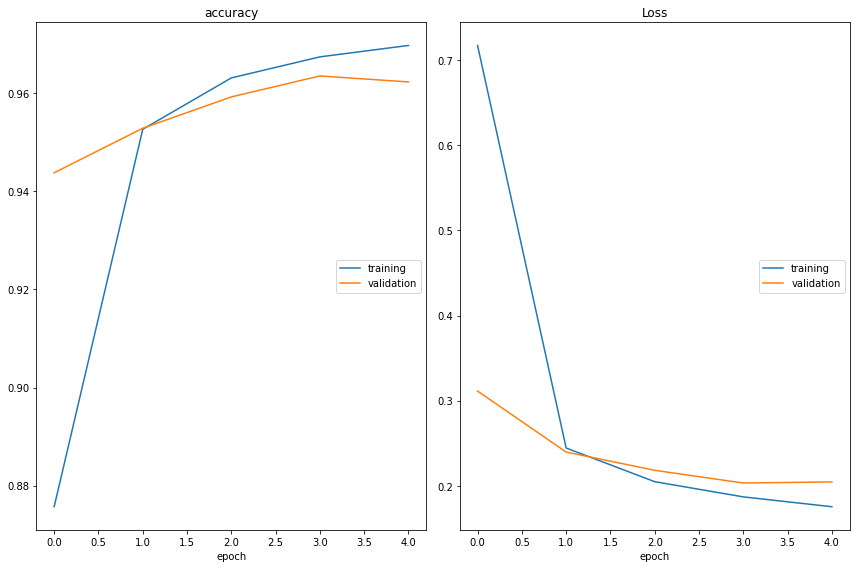

accuracy
	training         	 (min:    0.876, max:    0.970, cur:    0.970)
	validation       	 (min:    0.944, max:    0.963, cur:    0.962)
Loss
	training         	 (min:    0.175, max:    0.717, cur:    0.175)
	validation       	 (min:    0.203, max:    0.311, cur:    0.204)
75/75 [==============================] - 12s 161ms/step - loss: 0.1753 - accuracy: 0.9697 - val_loss: 0.2045 - val_accuracy: 0.9623


In [618]:
early_stop= EarlyStopping(monitor='val_accuracy',patience=1,verbose=0,mode='max',restore_best_weights=False)
callbacks=[PlotLossesCallback(),early_stop]
history=model.fit(X_train,np.array(y_train), validation_data=(X_valid, np.array(y_valid)), batch_size=32, epochs=10, verbose=1, callbacks=callbacks)

In [619]:
model.evaluate(X_train,np.array(y_train))

75/75 [==============================] - 2s 26ms/step - loss: 0.1700 - accuracy: 0.9685


[0.16999386250972748, 0.9684780836105347]

In [620]:
print(X_test[3])
print(idx2word[1])
p = model.predict(np.array([X_test[3]]))
p = np.argmax(p, axis=-1)
print(t_index)
print(p)

[  9. 229.  54.  64. 363. 722. 183.  76.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
__isMention__
1/1 [==============================] - 0s 455ms/step
{'I-company': 1, 'B-movie': 2, 'I-musicartist': 3, 'B-product': 4, 'I-sportsteam': 5, 'I-product': 6, 'B-other': 7, 'I-geo-loc': 8, 'I-other': 9, 'B-sportsteam': 10, 'B-tvshow': 11, 'B-musicartist': 12, 'B-person': 13, 'B-geo-loc': 14, 'B-facility': 15, 'I-person': 16, 'I-facility': 17, 'I-tvshow': 18, 'I-movie': 19, 'B-company': 20, 'O': 21}
[[21 21 21 21 21 21 21  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
   0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]]
